# Using Pretrained Pipeline from Spark NLP for Price Prediction

Install PySpark and Spark NLP Libraries

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2023-12-16 22:23:11--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2023-12-16 22:23:11--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2023-12-16 22:23:11 (79.1 MB/s) - written to stdout [1191/1191]

Installing

Import Required Libaries and Methods

In [ ]:
# Imports the main PySpark library, providing access to functionalities for distributed computing.
import pyspark
# Creates and manages SparkSession, which is the entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession
# Imports Window functions for defining window specifications in DataFrame operations
from pyspark.sql.window import Window
# Imports the functions module from PySpark SQL, allowing access to various built-in functions for DataFrame operations
from pyspark.sql import functions as F
# Imports specific functions commonly used in DataFrame operations
from pyspark.sql.functions import col, regexp_replace, count, isnan, when
# Imports the Pipeline class for assembling multiple stages into a single workflow.
from pyspark.ml import Pipeline
# Used to evaluate multiclass classification models based on different metrics like accuracy, precision, recall, etc.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Imports the Spark NLP library, enabling access to functionalities for NLP
import sparknlp
# Import various classes, methods, and utilities from Spark NLP for base functionalities,
# common components, and annotators
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

Install matplotlib for creating charts

In [ ]:
!pip install matplotlib pandas
import matplotlib.pyplot as plt

Initiate SparkContext and SparkSession and Import Google Drive Module

In [ ]:
# Initiates a SparkContext and a SparkSession using the Spark NLP library
spark = sparknlp.start()

# Check version of the Spark NLP library and Apache Spark being used in the
# current Spark session
print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 5.2.0
Apache Spark version: 3.2.3


In [ ]:
# This line imports the drive module from the google.colab library
from google.colab import drive
# Mounts your Google Drive into the Colab environment at the specified directory path /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing PySpark functions for DataFrame operations
from pyspark.sql.functions import *

Function Definition: Converting CSV to DataFrame

In [ ]:
# Method to convert CSV to pandas DataFrame
def csv_to_df(file_path):
    """
      Converts a CSV file to a pandas DataFrame

      Parameters:
         file_path: The name of the CSV file, to be converted into a pandas DataFrame

      Returns:
         df: The newly created pandas DataFrame
    """

    # File location and type
    file_type = "csv" # Specify that the file type is a CSV. Other file types will be ignored.

    # CSV options
    infer_schema = "true" # Infer schema automatically while reading the CSV
    first_row_is_header = "true" # Treat the first row as header
    delimiter = "," # Define the delimiter used in the CSV file

   # Read the CSV file into a DataFrame using Spark
   # Allowing multiline entries in the CSV
   # Specifying an escape character for CSV entries
    df = spark.read.format(file_type) \
         .option("inferSchema", infer_schema) \
         .option("header", first_row_is_header) \
         .option("sep", delimiter) \
         .option("multiline","True") \
         .option("escape","\"") \
         .load(file_path)

    # Return DataFrame
    return df

Load Sample CSV of ~10000 Reviews from Google Drive and Convert it to a DataFrame

In [ ]:
# Load the selected ~10,000 reviews
selected_reviews_file_name = "selected_10000_reviews.csv"
file_path = "/content/drive/My Drive/ENSF-612/project-files/" + selected_reviews_file_name
selected_reviews_df = csv_to_df(file_path)

In [ ]:
# Inspect the columns of the selected reviews DataFrame
print(selected_reviews_df.columns)

['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'review_num', 'comments']


Load CSV of London Airbnb Listings and Convert it to a DataFrame:

In [ ]:
# Load the listings data
listings_data_file_name = "listings.csv"
file_path = "/content/drive/My Drive/ENSF-612/project-files/" + listings_data_file_name
listings_df = csv_to_df(file_path)

In [ ]:
# Inspect the columns of the listings dataframe
print(listings_df.columns)

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Inspect the number of rows for each DataFrame:

In [ ]:
print("number of listings:", listings_df.count())

number of listings: 87946


In [ ]:
print("number of listings:", listings_df.count())
print("number of reviews:", selected_reviews_df.count())

number of listings: 87946
number of reviews: 9998


Inspect the number of missing values in each DataFrame:

In [ ]:
# View number of missing values in listings_df
listings_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in listings_df.columns]).show()

+---+-----------+---------+------------+------+----+-----------+---------------------+-----------+-------+--------+---------+----------+-------------+----------+------------------+------------------+--------------------+-----------------+------------------+----------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+-------------+----------------------+----------------------------+--------+---------+-------------+---------+------------+---------+--------------+--------+----+---------+-----+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------+-----------------+---------------------+----------------------+------------+-----------+--------------------+----------------------+

In [ ]:
# View number of missing values in selected_reviews_df
selected_reviews_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in selected_reviews_df.columns]).show()

+----------+---+----+-----------+-------------+----------+--------+
|listing_id| id|date|reviewer_id|reviewer_name|review_num|comments|
+----------+---+----+-----------+-------------+----------+--------+
|         0|  0|   0|          0|            1|         0|       0|
+----------+---+----+-----------+-------------+----------+--------+



Feature Selection: removing unimportant features, or features with too many missing values

In [ ]:
# Rename "comments" column to "text" for use with the pre-trained pipeline
selected_reviews_df = selected_reviews_df.withColumnRenamed("comments", "text")

# Select desired features from the selected reviews
selected_reviews_df = selected_reviews_df.select("listing_id", "id", "text")

In [ ]:
# Rename neighbourhood_cleansed column to neighbourhood_name - more intuitive name
listings_df  = listings_df.withColumnRenamed("neighbourhood_cleansed", "neighbourhood_name")

# Select desired features from the listings data
listings_df = listings_df.select("id","price","neighbourhood_name","room_type","beds","availability_365", "number_of_reviews")


Features like bathrooms and bedrooms would normally be considered important features, but the large number of missing values made the choice of excluding them easy.

In [ ]:
# View number of missing values in listings_df
listings_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in listings_df.columns]).show()

+---+-----+------------------+---------+----+----------------+-----------------+
| id|price|neighbourhood_name|room_type|beds|availability_365|number_of_reviews|
+---+-----+------------------+---------+----+----------------+-----------------+
|  0|    0|                 0|        0|1134|               0|                0|
+---+-----+------------------+---------+----+----------------+-----------------+



We can see that there are 1134 missing values in the "beds" column. We will impute missing values with the median

In [ ]:
from pyspark.ml.feature import Imputer

impute_cols = ["beds"]
# Create an Imputer object that will replace missing values with the median
imputer = Imputer(inputCols=impute_cols, outputCols=[f"{col}_imputed" for col in impute_cols], strategy="median")

# Fit and transform the data
imputer_model = imputer.fit(listings_df)
listings_df = imputer_model.transform(listings_df)

# Replace the "beds" column with "beds_imputed"
listings_df = listings_df.drop("beds")
listings_df = listings_df.withColumnRenamed("beds_imputed", "beds")

# Cache DataFrame for future use
listings_df.cache()

DataFrame[id: bigint, price: string, neighbourhood_name: string, room_type: string, availability_365: int, number_of_reviews: int, beds: int]

In [ ]:
# View number of missing values in listings_df after imputation
listings_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in listings_df.columns]).show()

+---+-----+------------------+---------+----------------+-----------------+----+
| id|price|neighbourhood_name|room_type|availability_365|number_of_reviews|beds|
+---+-----+------------------+---------+----------------+-----------------+----+
|  0|    0|                 0|        0|               0|                0|   0|
+---+-----+------------------+---------+----------------+-----------------+----+



Load the Pre-trained Sentiment Analysis Pipeline from Spark NLP, which includes a model trained on IMDB Reviews and uses the Universal Sentence Encoder Embeddings:

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

# Load the pre-trained sentiment analysis pipeline
# Universal sentence encoder embeddings and trained on IMDB reviews
pretrained_pipeline = PretrainedPipeline('analyze_sentimentdl_use_imdb', lang='en')

analyze_sentimentdl_use_imdb download started this may take some time.
Approx size to download 935.7 MB
[OK!]


Let's apply this pipeline to transform to our entire selected_reviews_df DataFrame now:

In [ ]:
# Apply the pipeline to the training and test data
sentiment_predictions = pretrained_pipeline.transform(selected_reviews_df)

In [ ]:
# Extract predicted label and probabilities and create new columns
sentiment_predictions = sentiment_predictions.withColumn("predicted_sentiment", sentiment_predictions.sentiment.result[0]
                        ).withColumn("positive_confidence", sentiment_predictions.sentiment.metadata[0].getItem('pos')
                        ).withColumn("negative_confidence", sentiment_predictions.sentiment.metadata[0].getItem('neg'))

In [ ]:
# Group by the predicted sentiment and count the occurrences in the trained dataset
sentiment_predictions_distribution = sentiment_predictions.groupBy("predicted_sentiment").count()

# Show the distribution
sentiment_predictions_distribution.cache()
sentiment_predictions_distribution.show()

+-------------------+-----+
|predicted_sentiment|count|
+-------------------+-----+
|                pos| 9758|
|                neg|  230|
|            neutral|   10|
+-------------------+-----+



## Plot the Predictions Distribution

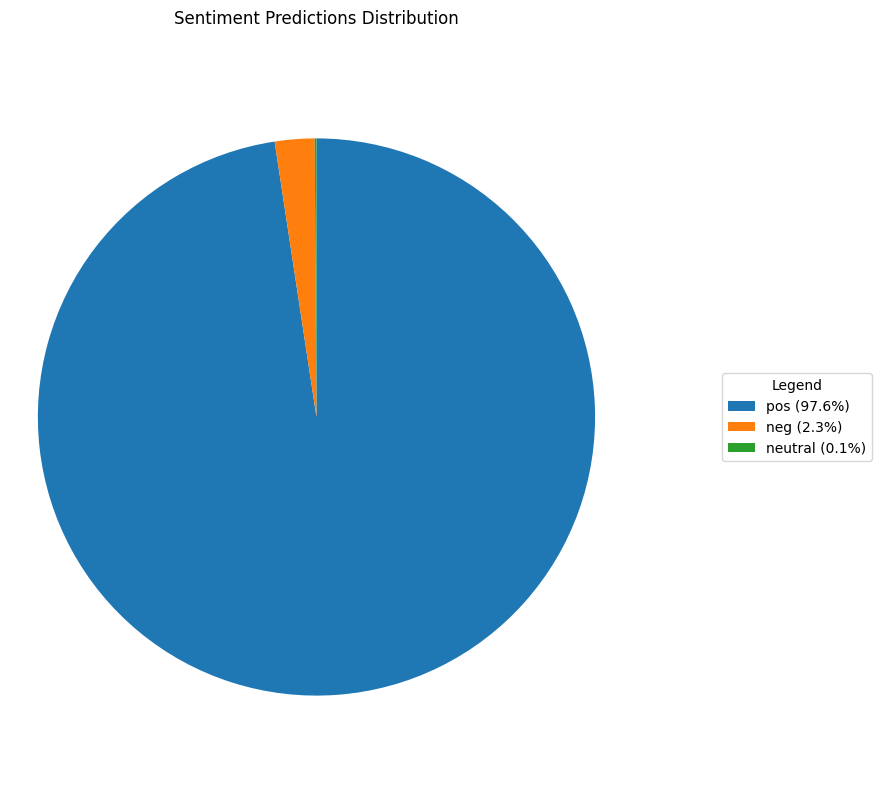

In [ ]:
# Convert "count" to float
sentiment_predictions_distribution = sentiment_predictions_distribution.withColumn("count", col("count").cast("float"))

# Extract data from the PySpark DataFrame
# We can use collect() here because the dataframe is very small
categories = sentiment_predictions_distribution.select("predicted_sentiment").rdd.flatMap(lambda x: x).collect()
values = sentiment_predictions_distribution.select("count").rdd.flatMap(lambda x: x).collect()
# Calculate percentages for the legend
# total_count = sum(values)
total_count = sentiment_predictions_distribution.agg(sum(col("count"))).collect()[0][0]
percentages = [(count / total_count) * 100 for count in values]

# Plot a pie chart using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(values, labels=None, autopct='', pctdistance=0.85, startangle=90, counterclock=False)

# Create custom legend with labels and percentages
legend_labels = [f'{label} ({size:.1f}%)' for label, size in zip(categories, percentages)]
ax.legend(wedges, legend_labels, title='Legend', loc='center left', bbox_to_anchor=(0.9, 0.5), bbox_transform=plt.gcf().transFigure)

# Adjust layout parameters
ax.axis('equal')
plt.tight_layout()

plt.title('Sentiment Predictions Distribution')
plt.show()

As expected, most of the predicted sentiments were positive.

In [ ]:
# Clear cached dataframe to free up memory
sentiment_predictions_distribution.unpersist()

DataFrame[predicted_sentiment: string, count: float]

Map Labels and Predictions from Strings to Numerical Values

In [ ]:
# Map string sentiment predictions to numerical values
# 1 - positive
# 0 - neutral
# -1 - negative
sentiment_predictions = sentiment_predictions.withColumn(
    "predicted_sentiment_numeric",
    when(col("predicted_sentiment") == "pos", 1.0)
    .when(col("predicted_sentiment") == "neg", -1.0)
    .otherwise(0.0)
)

sentiment_predictions.select("text", "predicted_sentiment", "predicted_sentiment_numeric").show(truncate=60)
sentiment_predictions.cache()

+------------------------------------------------------------+-------------------+---------------------------+
|                                                        text|predicted_sentiment|predicted_sentiment_numeric|
+------------------------------------------------------------+-------------------+---------------------------+
|It was a very pleasant experience in a quiet street.  Syl...|                pos|                        1.0|
|We really enjoyed our stay. Room was small, cozy and quie...|                pos|                        1.0|
|Sylan is a very lovely lady. She has a beautiful and cozy...|                pos|                        1.0|
|Sylvan's place was ideal for the 3 day conference I atten...|                pos|                        1.0|
|  Sylvan was very kind.\rThe room was perfect for our needs.|                pos|                        1.0|
|Tremendous accomodation in a quiet street & a very welcom...|                pos|                        1.0|
|

DataFrame[listing_id: int, id: bigint, text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence_embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentiment: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, predicted_sentiment: string, positive_confidence: string, negative_confidence: string, predicted_sentiment_numeric: double]

Calculate the mean sentiment value for each listing_id

In [ ]:
# Group the DataFrame by 'listing_id' and compute the mean of 'predicted_sentiment_numeric' column for each group
reviews_with_predictions_df  = sentiment_predictions.groupBy('listing_id').agg(mean("predicted_sentiment_numeric").alias("mean_prediction"))

# cache the dataframe for future use
reviews_with_predictions_df.cache()

# Display the resulting DataFrame 'reviews_with_predictions_df'
display(reviews_with_predictions_df)
reviews_with_predictions_df.show()
print("Number of listings:", reviews_with_predictions_df.count())

DataFrame[listing_id: int, mean_prediction: double]

+----------+---------------+
|listing_id|mean_prediction|
+----------+---------------+
|     92644|            1.0|
|    396523|            1.0|
|  13796326|            1.0|
|  14273054|            0.9|
|  16108857|            1.0|
|  21617650|            1.0|
|    310949|            1.0|
|    521982|            0.9|
|   6087949|            1.0|
|  13316054|            1.0|
|  14687256|            0.7|
|  19472116|            1.0|
|  31847860|            1.0|
|  32867236|            1.0|
|    107051|            0.9|
|   9751730|            1.0|
|    183128|            1.0|
|    571265|            1.0|
|   7878442|            1.0|
|  15529515|            1.0|
+----------+---------------+
only showing top 20 rows

Number of listings: 500


Combining the Airbnb London Listings and the Reviews with Average Sentiment Predictions

In [ ]:
# Perform an inner join based on id in listings_df with listing_id in reviews_with_predictions_df
combined_df = listings_df.join(reviews_with_predictions_df, listings_df.id == reviews_with_predictions_df.listing_id , "inner")

# Rename neighbourhood_cleansed column to neighbourhood_name - more intuitive name
combined_df  = combined_df.withColumnRenamed("neighbourhood_cleansed", "neighbourhood_name")

# Select desired fields for the combined_df
# combined_df = combined_df.select("id","price","neighbourhood_name","room_type","number_of_reviews","availability_365","mean_prediction")
combined_df = combined_df.select("id","price","neighbourhood_name","room_type","beds","number_of_reviews","availability_365","mean_prediction")

# Cache the combine dataframe
combined_df.cache()

# Display the DataFrame 'combined_df'
combined_df.show()

+------+-------+--------------------+---------------+----+-----------------+----------------+---------------+
|    id|  price|  neighbourhood_name|      room_type|beds|number_of_reviews|availability_365|mean_prediction|
+------+-------+--------------------+---------------+----+-----------------+----------------+---------------+
| 92644| $42.00|          Wandsworth|   Private room|   2|              216|             217|            1.0|
|102565|$120.00|             Lambeth|   Private room|   1|              374|             270|            1.0|
| 36660| $82.00|            Haringey|   Private room|   1|              639|             186|            1.0|
|107051|$221.00|         Westminster|Entire home/apt|   3|              655|             219|            0.9|
| 42010| $65.00|              Barnet|   Private room|   1|              549|             214|            1.0|
| 43129| $60.00|Hammersmith and F...|   Private room|   1|              234|             347|            1.0|
| 46992| $

In [ ]:
# Unpersist DataFrames no longer needed to free memory
listings_df.unpersist()
reviews_with_predictions_df.unpersist()

DataFrame[listing_id: int, mean_prediction: double]

# Feature Engineering

Clean the $ Sign from Price and Convert Price to Integer in the Combined DataFrame

In [ ]:
# Import necessary functions from PySpark
from pyspark.sql.functions import regexp_replace, col

# Remove the dollar sign ('$') from the 'price' column in combined_df and convert it to an integer
combined_df = combined_df.withColumn("price", regexp_replace(col("price"), "\$", "").cast("integer"))

# Display the DataFrame 'combined_df'
combined_df.show()

+------+-----+--------------------+---------------+----+-----------------+----------------+---------------+
|    id|price|  neighbourhood_name|      room_type|beds|number_of_reviews|availability_365|mean_prediction|
+------+-----+--------------------+---------------+----+-----------------+----------------+---------------+
| 92644|   42|          Wandsworth|   Private room|   2|              216|             217|            1.0|
|102565|  120|             Lambeth|   Private room|   1|              374|             270|            1.0|
| 36660|   82|            Haringey|   Private room|   1|              639|             186|            1.0|
|107051|  221|         Westminster|Entire home/apt|   3|              655|             219|            0.9|
| 42010|   65|              Barnet|   Private room|   1|              549|             214|            1.0|
| 43129|   60|Hammersmith and F...|   Private room|   1|              234|             347|            1.0|
| 46992|   58|             H

Create Pipeline to Index and One-Hot Encode Categorical Variables

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Define categorical and numeric feature columns
categorical_features = ["neighbourhood_name", "room_type"]
numeric_features = ["number_of_reviews", "beds", "availability_365", "mean_prediction"]

# Initialize an empty list to store pipeline stages
stages = []

# Loop through categorical features for transformation
for col_name in categorical_features:
    # Create a StringIndexer for each categorical column to index the categorical values
    stringIndexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")

    # Create a OneHotEncoder to convert indexed categorical values into binary vectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], \
                            outputCols=[col_name + "_encoded"])

    # Add both the StringIndexer and OneHotEncoder to the stages list
    stages += [stringIndexer, encoder]

categorical_features_enc = [col + "_encoded" for col in categorical_features]

# Assemble only numeric features into a single vector column
numeric_assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features")

# Add the numeric VectorAssembler to the stages list
stages += [numeric_assembler]

# Standardize numeric features
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features", withStd=True, withMean=True)

# Add the StandardScaler to the stages list
stages += [scaler]

# Assemble all features into a single vector column after scaling
final_assembler = VectorAssembler(inputCols=["scaled_features"] + categorical_features_enc, outputCol="features")


# Add the final VectorAssembler to the stages list
stages += [final_assembler]

# Create the pipeline
preprocessing_pipeline = Pipeline(stages=stages)

Split Combined DataFrame into Training and Testing Sets and Apply Pipeline Transformations to Each of Them

In [ ]:
# Randomly split the df_processed_with_hash into training (70%) and testing sets (30%)
train, test = combined_df.randomSplit([0.70, 0.30], seed=39)

In [ ]:
# Fit the pipeline on the training set and use it to transform both training and test set
pipeline_model = preprocessing_pipeline.fit(train)

# Transform training and test sets
train_preprocessed = pipeline_model.transform(train)
test_preprocessed = pipeline_model.transform(test)

In [ ]:
# Display the result of the transformation
train_preprocessed.show(truncate=False)

+------+-----+----------------------+---------------+----+-----------------+----------------+---------------+------------------------+--------------------------+---------------+-----------------+---------------------+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|id    |price|neighbourhood_name    |room_type      |beds|number_of_reviews|availability_365|mean_prediction|neighbourhood_name_index|neighbourhood_name_encoded|room_type_index|room_type_encoded|numeric_features     |scaled_features                                                                 |features                                                                                                     |
+------+-----+----------------------+---------------+----+-----------------+----------------+---------------+------------------------+--------------------------+---------------+-----

#Linear Regression

Function Definition: Regression Model Evaluation Metrics

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

def eval(train_predictions, test_predictions):
    """
        Evaluates the performance of a regression model by calculating the Root Mean Squared Error, Mean Squared Error,
        Mean Absolute Error, and R-squared for both the train_predictions and test_predictions and printing them

        Parameters:
            train_predictions: DataFrame with the price output values predicted on training set
            train_predictions: DataFrame with the price output values predicted on testing set

        Returns:
            None
    """

    # Initialize a RegressionEvaluator specifying evaluation parameters
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

    # Calculate the evaluation metrics
    # Calculate the root mean squared error
    rmse_train = evaluator.evaluate(train_predictions)
    rmse_test = evaluator.evaluate(test_predictions)

    # Calculate the mean squared error
    mse_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
    mse_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})

    # Calculate the mean absolute error
    mae_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
    mae_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})

    # Calculate the R-squared
    r2_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "r2"})
    r2_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})

    # Print evaluation metrics
    print(f"Root Mean Squared Error (RMSE):\nTraining RMSE: {rmse_train} \nTesting RMSE: {rmse_test}\n")
    print(f"Mean Squared Error (MSE): \nTraining MSE: {mse_train} \nTesting MSE: {mse_test}\n")
    print(f"Mean Absolute Error (MAE): \nTraining MAE: {mae_train} \nTesting MAE: {mae_test}\n")
    print(f"R-squared (R²): \nTraining R²: {r2_train} \nTesting R²: {r2_test}\n")

Price Prediction using Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

# Create a Linear Regression instance
lr = LinearRegression(featuresCol='features', labelCol='price')

# Train the model using the training data
lr_model = lr.fit(train_preprocessed)

# Make predictions on the training data
lr_train_predictions = lr_model.transform(train_preprocessed)

# Make predictions on the testing data
lr_test_predictions = lr_model.transform(test_preprocessed)

In [ ]:
# View train_predictions
lr_train_predictions.select('price', 'prediction').show(5)

+-----+-----------------+
|price|       prediction|
+-----+-----------------+
|   82|66.65767317483407|
|   65| 63.4744017421737|
|   60|73.11806789352043|
|   58|61.55386439549345|
|   54|90.77480360618578|
+-----+-----------------+
only showing top 5 rows



In [ ]:
# View test_predictions
lr_test_predictions.select('price', 'prediction').show(5)

+-----+-----------------+
|price|       prediction|
+-----+-----------------+
|   75|75.29461195213689|
|   94|146.3800445066409|
|  221|209.1855175262528|
|   68|  81.266739913325|
|   40|54.15299454461368|
+-----+-----------------+
only showing top 5 rows



In [ ]:
# Call eval method to get evaluation metrics
eval(lr_train_predictions, lr_test_predictions)

Root Mean Squared Error (RMSE):
Training RMSE: 37.3470457918274 
Testing RMSE: 43.676731992937874

Mean Squared Error (MSE): 
Training MSE: 1394.8018293768528 
Testing MSE: 1907.656917582923

Mean Absolute Error (MAE): 
Training MAE: 26.762636601488854 
Testing MAE: 27.92936338889533

R-squared (R²): 
Training R²: 0.5967494113049975 
Testing R²: 0.5804907480337824



The testing RMSE is higher than the training RMSE, suggesting some degree of overfitting or a less accurate model on unseen data. It is encouraging that the two values are not drastically different though. The R-squared value also attests to this, as the testing R-squared being lower than the training R-squared indicates that the model may not generalize as well to unseen data.



Next, we can tune the hyper parameters using cross-validation to achieve an even better Linear Regression model.

##Using Cross-Validation to find Best Hyperparameters for Linear Regression Model

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add a 'label' column to the scaled training and test datasets, derived from the 'price' column.
# This 'label' column is used for training the regression model.
temp_train = train_preprocessed.withColumn('label', train_preprocessed["price"])
temp_test= test_preprocessed.withColumn('label', test_preprocessed["price"])

# Create a Linear Regression instance
lr = LinearRegression(featuresCol='features', labelCol='price')

# Creates a grid of hyperparameters (paramGrid) for cross-validation using ParamGridBuilder.
# Defines combinations of different values for regularization parameters (regParam), elastic net parameters (elasticNetParam), and maximum iterations (maxIter) to search over during cross-validation.
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [ 0.0, 0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()



# Use CrossValidator to perform cross-validation and find the best hyperparameters
# Sets up a CrossValidator (crossval) that uses the Linear Regression model (lr), the defined parameter grid (paramGrid), a regression evaluator (evaluator) to assess model performance using RMSE (Root Mean Squared Error), and performs 5-fold cross-validation (numFolds=5).
evaluator = RegressionEvaluator(metricName="rmse")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
# Fits the CrossValidator (crossval) on the training data (temp_train) to find the best combination of hyperparameters using cross-validation.
lr_cv_model = crossval.fit(temp_train)


# Make predictions on the test data using the best model from cross-validation
lr_tuned_train_predictions = lr_cv_model.transform(temp_train)
lr_tuned_test_predictions = lr_cv_model.transform(temp_test)

In [ ]:
# View train_predictions
lr_tuned_train_predictions.select('price', 'prediction').show(5)

+-----+-----------------+
|price|       prediction|
+-----+-----------------+
|   82|68.34524819314332|
|   65|64.87124239593832|
|   60|78.22061309059762|
|   58|64.00245383756118|
|   54|92.94646648908028|
+-----+-----------------+
only showing top 5 rows



In [ ]:
# View test_predictions
lr_tuned_test_predictions.select('price', 'prediction').show(5)

+-----+------------------+
|price|        prediction|
+-----+------------------+
|   75| 74.13580075044032|
|   94|148.31270429313608|
|  221|202.43923534693081|
|   68|  81.4058422226461|
|   40| 55.71065941228398|
+-----+------------------+
only showing top 5 rows



In [ ]:
# Access the best model obtained from cross-validation
lr_best_model = lr_cv_model.bestModel

# Get the specific hyperparameters used in the best model
lr_best_model_params = lr_best_model.extractParamMap()

# Print or display the best hyperparameters
print("Best Hyperparameters:")
for param_key, param_value in lr_best_model_params.items():
    print(f"{param_key.name}: {param_value}")

Best Hyperparameters:
aggregationDepth: 2
elasticNetParam: 0.7
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: price
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 10
predictionCol: prediction
regParam: 0.1
solver: auto
standardization: True
tol: 1e-06


In [ ]:
# Call eval method to get evaluation metrics
eval(lr_tuned_train_predictions, lr_tuned_test_predictions)

Root Mean Squared Error (RMSE):
Training RMSE: 37.906486518757596 
Testing RMSE: 44.916637160136695

Mean Squared Error (MSE): 
Training MSE: 1436.9017201967515 
Testing MSE: 2017.5042937753728

Mean Absolute Error (MAE): 
Training MAE: 26.895036897249447 
Testing MAE: 28.365622067567045

R-squared (R²): 
Training R²: 0.5845779290201598 
Testing R²: 0.5563344177250107



Unfortunately, the hyperparameter tuning did not have the desired effect, as both the training and testing RMSE both slightly increased. It’s not always guaranteed that tuning will always lead to better results, especially if the original model is already performing reasonably well or when the effects of the hyperparameters are limited. Given that the changes in RMSE are slight, it’s possible that the original configuration of the linear regression model was already optimal.

#Decision Tree

Price Prediction using Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

# Create a Decision Tree instance
dt = DecisionTreeRegressor(featuresCol="features", labelCol="price")

# Train the model using the training data
dt_model = dt.fit(train_preprocessed)

# Make predictions on the training data
dt_train_predictions = dt_model.transform(train_preprocessed)

# Make predictions on the testing data
dt_test_predictions = dt_model.transform(test_preprocessed)

In [ ]:
# View train_predictions
dt_train_predictions.select('price', 'prediction').show(5)

+-----+-----------------+
|price|       prediction|
+-----+-----------------+
|   82|65.82142857142857|
|   65|65.82142857142857|
|   60|65.82142857142857|
|   58|56.18811881188119|
|   54|65.82142857142857|
+-----+-----------------+
only showing top 5 rows



In [ ]:
# View test_predictions
dt_test_predictions.select('price', 'prediction').show(5)

+-----+------------------+
|price|        prediction|
+-----+------------------+
|   75| 65.82142857142857|
|   94|110.69444444444444|
|  221|149.91666666666666|
|   68| 65.82142857142857|
|   40| 65.82142857142857|
+-----+------------------+
only showing top 5 rows



In [ ]:
# Call eval method to get evaluation metrics
eval(dt_train_predictions, dt_test_predictions)

Root Mean Squared Error (RMSE):
Training RMSE: 30.900950867497436 
Testing RMSE: 53.54717166402574

Mean Squared Error (MSE): 
Training MSE: 954.8687645154905 
Testing MSE: 2867.299593216641

Mean Absolute Error (MAE): 
Training MAE: 22.519602616675886 
Testing MAE: 33.09247410986642

R-squared (R²): 
Training R²: 0.7239382804728838 
Testing R²: 0.36945752853850533



The testing RMSE is considerably higher than the training RMSE and the testing R-Squared is less than the training R-Squared for this Decision Tree Model, suggesting overfitting or less accuracy on unseen data.

Let's also use cross-validation to find the best hyperparameters for decision tree model, just to see how it compares to those of the linear regression.

##Using Cross-Validation to find Best Hyperparameters for Decision Tree Model

In [ ]:
# Create a Decision Tree instance
dt = DecisionTreeRegressor(featuresCol="features", labelCol="price")


# Evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="price", predictionCol="prediction")


# Parameter Grid
paramGrid = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [5, 10, 15])
              .addGrid(dt.minInstancesPerNode, [1, 5, 10])
              .addGrid(dt.minInfoGain, [0.0, 0.1, 0.2])
              .build())

# CrossValidator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Number of folds for cross-validation

# Fit the CrossValidator to the Data
dt_cv_model = crossval.fit(temp_train)


In [ ]:
# Access the best model obtained from cross-validation
dt_best_model = dt_cv_model.bestModel

# Get the specific hyperparameters used in the best model
dt_best_model_params = dt_best_model.extractParamMap()

# Print or display the best hyperparameters
print("Best Hyperparameters:")
for param_key, param_value in dt_best_model_params.items():
    print(f"{param_key.name}: {param_value}")

Best Hyperparameters:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: variance
labelCol: price
leafCol: 
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 10
minWeightFractionPerNode: 0.0
predictionCol: prediction
seed: -4252346092290327729


In [ ]:
# Make predictions on the test data using the best model from cross-validation
dt_tuned_train_predictions = dt_best_model.transform(temp_train)
dt_tuned_test_predictions = dt_best_model.transform(temp_test)

In [ ]:
# Call eval method to get evaluation metrics
eval(dt_tuned_train_predictions, dt_tuned_test_predictions)

Root Mean Squared Error (RMSE):
Training RMSE: 38.1098088645374 
Testing RMSE: 51.71463245139917

Mean Squared Error (MSE): 
Training MSE: 1452.3575316915735 
Testing MSE: 2674.403209583308

Mean Absolute Error (MAE): 
Training MAE: 25.09710504434003 
Testing MAE: 31.951784023091545

R-squared (R²): 
Training R²: 0.5801095056550782 
Testing R²: 0.4118770101859387



The gap between the training and testing RMSE for the tuned Decision Tree model has decreased, which resulted from the training RMSE by increasing nearly 8 and the testing RMSE decreasing by nearly 2. There is less overfitting than the untuned model.

#Gradient Boosting

Price Prediction using Gradient Boosting

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Create a Decision Tree instance
gbt = GBTRegressor(featuresCol="features", labelCol="price", maxIter=10)

# Train the model using the training data
gbt_model = gbt.fit(train_preprocessed)

# Make predictions on the training data
gbt_train_predictions = gbt_model.transform(train_preprocessed)

# Make predictions on the testing data
gbt_test_predictions = gbt_model.transform(test_preprocessed)

# View train_predictions
gbt_train_predictions.select('price', 'prediction').show(5)

+-----+-----------------+
|price|       prediction|
+-----+-----------------+
|   82|74.47215436880867|
|   65|63.93474641343532|
|   60| 66.3503542745183|
|   58|52.86540289681834|
|   54|65.74000980770369|
+-----+-----------------+
only showing top 5 rows



In [ ]:
# View test_predictions
gbt_test_predictions.select('price', 'prediction').show(5)

+-----+------------------+
|price|        prediction|
+-----+------------------+
|   75| 63.93474641343532|
|   94|110.42679363210976|
|  221|157.35725150385076|
|   68| 63.48914950184334|
|   40|  70.5598618381116|
+-----+------------------+
only showing top 5 rows



In [ ]:
# Call eval method to get evaluation metrics
eval(gbt_train_predictions, gbt_test_predictions)

Root Mean Squared Error (RMSE):
Training RMSE: 24.859822187788993 
Testing RMSE: 52.27963251959272

Mean Squared Error (MSE): 
Training MSE: 618.010759208486 
Testing MSE: 2733.159976383656

Mean Absolute Error (MAE): 
Training MAE: 18.449832226113518 
Testing MAE: 31.732369840722924

R-squared (R²): 
Training R²: 0.8213271611623804 
Testing R²: 0.39895591988863366



The gap between the training and testing RMSE values and the testing and training R-Squared are by far the largest out of the three models, and indicate overfitting and that the Gradient Boosting model may not generalize as well to unseen data.

##Using Cross-Validation to find Best Hyperparameters for Gradient Boosting Model

In [ ]:


# Create a Gradient boosting instance
gb = GBTRegressor(featuresCol="features", labelCol="price")

# Evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="price", predictionCol="prediction")


# Parameter Grid
paramGrid = (ParamGridBuilder()
              .addGrid(gb.maxDepth, [3, 5, 7])        # maximum depth of tree
              .addGrid(gb.maxIter, [10, 20, 50])     # number of trees
              .addGrid(gb.stepSize, [0.05, 0.1, 0.2]) # learning rate
              .build())

# CrossValidator
crossval = CrossValidator(estimator=gb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Number of folds for cross-validation

# Fit the CrossValidator to the Data
gb_cv_model = crossval.fit(temp_train)

In [ ]:
# Access the best model obtained from cross-validation
gb_best_model = gb_cv_model.bestModel

# Get the specific hyperparameters used in the best model
gb_best_model_params = gb_best_model.extractParamMap()

# Print or display the best hyperparameters
print("Best Hyperparameters:")
for param_key, param_value in gb_best_model_params.items():
    print(f"{param_key.name}: {param_value}")

Best Hyperparameters:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: price
leafCol: 
lossType: squared
maxBins: 32
maxDepth: 3
maxIter: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
seed: -5509487886082859689
stepSize: 0.05
subsamplingRate: 1.0
validationTol: 0.01


In [ ]:
# Make predictions on the test data using the best model from cross-validation
gb_tuned_train_predictions = gb_best_model.transform(temp_train)
gb_tuned_test_predictions = gb_best_model.transform(temp_test)

In [ ]:
# Call eval method to get evaluation metrics
eval(gb_tuned_train_predictions, gb_tuned_test_predictions)

Root Mean Squared Error (RMSE):
Training RMSE: 36.24323526851462 
Testing RMSE: 50.165641385314125

Mean Squared Error (MSE): 
Training MSE: 1313.5721027289017 
Testing MSE: 2516.5915755999413

Mean Absolute Error (MAE): 
Training MAE: 25.724827506849888 
Testing MAE: 30.012965914002027

R-squared (R²): 
Training R²: 0.6202337044858823 
Testing R²: 0.4465810703938984



After hyperparameter tuning was performed, the gap between the training and testing RMSE for the tuned Gradient Boosting model has decreased, which resulted from the training RMSE increasing by nearly 12 and the testing RMSE decreasing by nearly 2. There is now less overfitting than the untuned model.

In [ ]:
gb_tuned_train_predictions.show(5)

+-----+-----+--------------------+------------+----+-----------------+----------------+---------------+------------------------+--------------------------+---------------+-----------------+--------------------+--------------------+--------------------+-----+-----------------+
|   id|price|  neighbourhood_name|   room_type|beds|number_of_reviews|availability_365|mean_prediction|neighbourhood_name_index|neighbourhood_name_encoded|room_type_index|room_type_encoded|    numeric_features|     scaled_features|            features|label|       prediction|
+-----+-----+--------------------+------------+----+-----------------+----------------+---------------+------------------------+--------------------------+---------------+-----------------+--------------------+--------------------+--------------------+-----+-----------------+
|36660|   82|            Haringey|Private room|   1|              639|             186|            1.0|                    17.0|           (28,[17],[1.0])|            0.

In [ ]:
gb_tuned_test_predictions.show(5)

+------+-----+--------------------+---------------+----+-----------------+----------------+---------------+------------------------+--------------------------+---------------+-----------------+--------------------+--------------------+--------------------+-----+------------------+
|    id|price|  neighbourhood_name|      room_type|beds|number_of_reviews|availability_365|mean_prediction|neighbourhood_name_index|neighbourhood_name_encoded|room_type_index|room_type_encoded|    numeric_features|     scaled_features|            features|label|        prediction|
+------+-----+--------------------+---------------+----+-----------------+----------------+---------------+------------------------+--------------------------+---------------+-----------------+--------------------+--------------------+--------------------+-----+------------------+
| 85191|   75|             Lambeth|   Private room|   1|              517|             325|            0.9|                     5.0|            (28,[5],[1